# Introduction à l'apprentissage automatique

*Maxime Sangnier*

Octobre, 2021

## Contrôle continu

# Table of contents
1. [Consignes](#part1)
1. [Exercice](#part2)


# Consignes <a id="part1"></a>

1. Vos réponses doivent se trouver dans les cellules adéquates de **ce fichier**.
1. En fin d'épreuve, **exportez** votre notebook en fichier `html`.
1. **Téléversez** ensuite les fichiers `ipynb` **et** `html` dans ce dossier distant : [https://www.dropbox.com/request/oPQXE75uYGUWHtENZvqK](https://www.dropbox.com/request/oPQXE75uYGUWHtENZvqK).
1. La durée de l'épreuve est **1h**. Tous les documents sont autorisés.

Si vous n’arrivez pas à faire une question, **continuez** quand même l'exercice avec les éléments à votre disposition.

In [3]:
from sys import path
path.append('../')
from mllab import *
import matplotlib.pyplot as plt
import numpy as np


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Exercice <a id="part2"></a>
>Considérons le jeu de données défini par la matrice $X \in \mathbb R^{n \times 2}$ et par le vecteur d'étiquettes $y$ (respectivement représentés par `X` et `y`) suivant :

In [49]:
d = 2
n = 200

np.random.seed(314)
X = np.random.randn(n, d) + np.r_[np.tile([2, 1], (n//2, 1)), np.tile([-2, -1], (n//2, 1))]
w0 = 1.5*np.random.randn(2)
b0 = -np.mean(X@w0) + 0.5*np.random.randn()
p = 1 / (1 + np.exp(-(X@w0 + b0)))
y = 2 * np.random.binomial(1, p) - 1

>**Question 1.**
Afficher les probabilités `p` en fonction de `X@w0+b0`.
Quel est le modèle de génération des données (`X`, `y`) ?

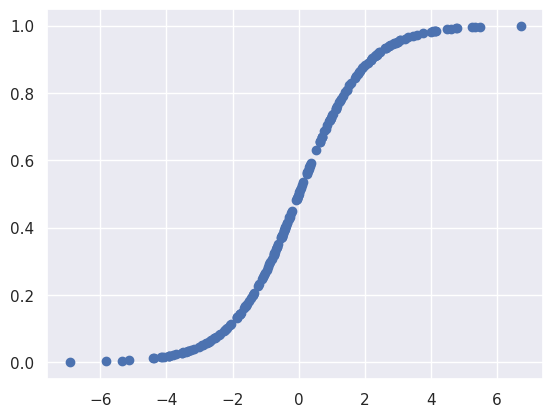

In [5]:
# Answer
plt.figure()
plt.scatter(X@w0 + b0, p)
plt.show()

**Answer:**

C'est le modèle de sigmoid.

>**Question 2.**
Afficher les données `X` en distingant leur classe par des couleurs différentes et tracer la droite d'équation $w_0^\top x +  b_0 = 0$ (on pourra s'aider de la fonction définie ci-dessous).
Que représente cette droite ?

In [6]:
fy = lambda x: -(b0 + w0[0]*x)/w0[1]

In [12]:
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin
class Linear(BaseEstimator, LinearClassifierMixin):
     def decision_function(self, X):
        # Compute decisions
        # Todo
        fy = lambda x: -(b0 + w0[0]*x)/w0[1]
        decisions = fy(X)
        # End todo
        return decisions
clf = Linear()
plot_frontiere(clf, data=X, data_labels=y, label=None, num=500)

ValueError: cannot reshape array of size 50000 into shape (50,500)

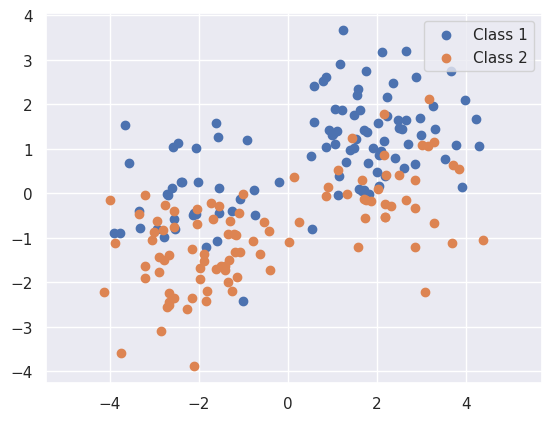

In [7]:
# Answer
X1 = X[y == -1]
X2 = X[y == 1]
plotXY(X1, X2, legend=True)
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
plt.show()

**Answer:**
…

>**Question 3.**
Soit la fonction de perte définie, pour tout $x \in \mathbb R$, par
$$
\ell(x) = -4x \mathbb 1_{x<-1} + \max (0, 1-x)^2 \mathbb 1_{x \ge -1}.
$$
Définir une fonction `loss(x)` retournant $[\ell(x_1), \dots, \ell(x_n)]$ pour `x`$=(x_1, \dots, x_n) \in \mathbb R^n$.
Représenter les graphes de $\ell$ et de la fonction $x \mapsto \mathbb 1_{x<0}$.

In [15]:
# Answer
def loss(X):
    mask = X < -1
    l1 = mask * (-4 * X)
    l2 = ~mask * np.maximum(0, 1 - X) ** 2 
    return l1 + l2

In [24]:
x = np.linspace(-5, 5, 500)
l = loss(x)
mask = x < 0 
y = mask * np.array([1] * x.shape[0])

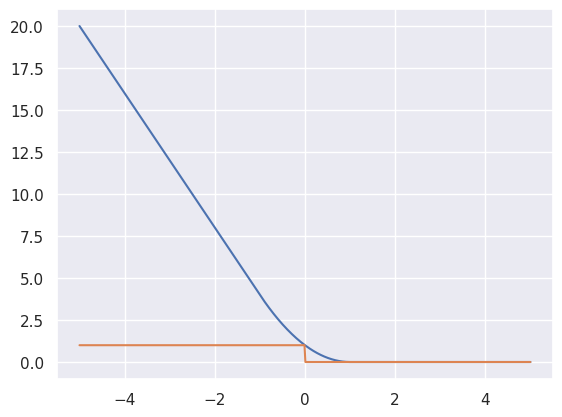

In [25]:
plt.plot(x, l)
plt.plot(x, y)
plt.show()

>**Question 4.**
En remarquant que $\ell$ est dérivable, définir une fonction `diff_loss(x)` retournant $[\ell'(x_1), \dots, \ell'(x_n)]$ pour `x`$=(x_1, \dots, x_n) \in \mathbb R^n$. Représenter le graphe de $\ell'$.

In [28]:
# Answer
def diff_loss(X):
    mask = X < -1
    l1 = mask * (-4)
    l2 = ~mask * (-2 * (1-X))
    return l1 + l2

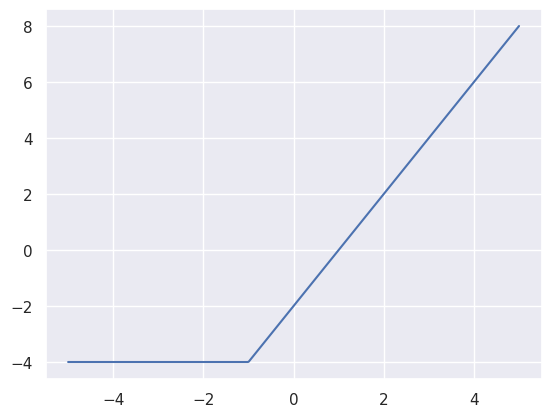

In [29]:
x = np.linspace(-5, 5, 500)
diff = diff_loss(x)
plt.plot(x, diff)
plt.show()


>**Question 5.**
Soient $\alpha>0$ et $x_1, \dots, x_n \in \mathbb R^2$ les lignes de la matrice $X$ (vus comme vecteurs colonne).
On souhaite fournir une solution numérique au problème d'optimisation
$$
\operatorname{minimiser}_{(w, b) \in \mathbb R^2 \times \mathbb R} ~ R(w, b),
\quad \text{avec} \quad R(w, b) = \frac \alpha 2 \|w\|_2^2 + \frac 1 n \sum_{i=1}^n \ell \left(y_i(w^\top x_i+b) \right).
$$
On définit la valeur numérique de $\alpha$ et le conteneur suivant :

In [54]:
alpha = 1.
data = X, y, alpha

>Définir une fonction `obj(w, b, data)` retournant $R(w, b)$ pour `w`$=w$ et `b`$=b$.
Afficher la valeur de $R(w_0, b_0)$.

In [56]:
# Answer
def obj(w, b, data):
    X, y, alpha = data
    n = X.shape[0]
    r = (alpha/2) * w@w.T + (1/n) * np.sum(loss((y * (X@w + b))))
    return r 

In [57]:
obj(w0, b0, data)

2.8069093120515882

>**Question 6.**
>Définir une fonction `grad(w, b, data)` retournant $\left[ \nabla_w R(w, b), \frac{\partial R}{\partial b}(w, b) \right]$ pour `w`$=w$ et `b`$=b$.
Pour ce faire, on pourra remarquer (mais ce n'est pas nécessaire), qu'il est possible de multiplier les lignes d'une matrice par différentes valeurs de la manière suivante :

In [ ]:
def grad(w, b, data):
    
    
    
    
    

In [60]:
a = np.arange(5)
B = np.ones((5, 2))
C = a[:, np.newaxis]*B
print(C)

[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]]


In [61]:
a

array([0, 1, 2, 3, 4])

In [64]:
a[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [62]:
B

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [63]:
C

array([[0., 0.],
       [1., 1.],
       [2., 2.],
       [3., 3.],
       [4., 4.]])

>Afficher les valeurs de $\nabla_w R(w_0, b_0)$ et $\frac{\partial R}{\partial b}(w_0, b_0)$.

In [ ]:
# Answer

>**En cas de problème.**
Si vous n'avez pas réussi à définir la fonction `grad(w, b, data)`, vous pouvez utiliser celle-ci :

In [12]:
from scipy.optimize import approx_fprime

def secure_grad(w, b, data):
    return approx_fprime(w, obj, 1e-5, b, data), approx_fprime(b, lambda x: obj(w, x, data), 1e-5)

secure_grad(w0, b0, data)

(array([0.1142699 , 2.33516422]), array([-0.07655231]))

>**Question 7.**
>Définir deux *lambda* fonctions `obj_b(b)` et `grad_obj_b(b)` retournant respectivement $R(w_0, b)$ et $\frac{\partial R}{\partial b}(w_0, b)$ pour `b`$=b$.
Représenter leurs graphes.

In [ ]:
# Answer
obj_b = lambda x: -(b0 + w0[0]*x)/w0[1]

def obj(w, b, data):
    X, y, alpha = data
    n = X.shape[0]
    r = (alpha/2) * w@w.T + (1/n) * np.sum(loss((y * (X@w + b))))
    return r 

>**Question 8.**
>Vérifier les valeurs numériques de $\nabla_w R(w_0, b_0)$ et $\frac{\partial R}{\partial b}(w_0, b_0)$ à l'aide de la fonction suivante :

In [14]:
from scipy.optimize import check_grad

help(check_grad)

Help on function check_grad in module scipy.optimize.optimize:

check_grad(func, grad, x0, *args, **kwargs)
    Check the correctness of a gradient function by comparing it against a
    (forward) finite-difference approximation of the gradient.
    
    Parameters
    ----------
    func : callable ``func(x0, *args)``
        Function whose derivative is to be checked.
    grad : callable ``grad(x0, *args)``
        Gradient of `func`.
    x0 : ndarray
        Points to check `grad` against forward difference approximation of grad
        using `func`.
    args : \*args, optional
        Extra arguments passed to `func` and `grad`.
    epsilon : float, optional
        Step size used for the finite difference approximation. It defaults to
        ``sqrt(np.finfo(float).eps)``, which is approximately 1.49e-08.
    
    Returns
    -------
    err : float
        The square root of the sum of squares (i.e., the 2-norm) of the
        difference between ``grad(x0, *args)`` and the finite

In [ ]:
# Answer

>**Question 9.**
>On donne ci-dessous les coefficients de Lipschitz continuité $L_w$ et $L_b$ de $\nabla_w R$ et $\frac{\partial R}{\partial b}$.

In [16]:
L_w = alpha + 2/n*np.linalg.norm(X.T@X, 2)
L_b = 2

L_w, L_b

(13.46147508005031, 2)

>Définir une fonction `optim(L_w, L_b, data, n_it=200)`, implémentant l'algorithme de résolution suivant pour le problème d'optimisation considéré:
>- Initialisation : $w=0$, $b=0$.
>- Itération :
    - $d_w \gets \nabla_w R(w, b)$ ;
    - $d_b = \frac{\partial R}{\partial b}(w, b)$ ;
    - $w \gets w - \frac{d_w}{L_w}$ ;
    - $b \gets b - \frac{d_b}{L_b}$ ;
>
>et retournant les valeurs $w$ et $b$.

>Afficher les données `X` en distingant leur classe par des couleurs différentes et tracer les droites d'équation $w_0^\top x + b_0 = 0$ et $w^\top x + b = 0$, où $w$ et $b$ sont les valeurs obtenues en sorti de l'algorithme.

In [ ]:
# Answer

>**Question 10.**
>Implémenter la méthode étudiée dans la classe suivante.
Afficher la frontière de décision à l'aide de la fonction `plot_frontiere` de `mllab` ainsi que le score obtenu pour les données considérée.

In [ ]:
# Answer
class METHOD:
    def __init__(self, alpha=1, n_iter=200):
        self.alpha = alpha
        self.n_iter = n_iter
        
    def fit(self, X, y):
        # To do

        # End to do
        return self
        
    def decision_function(self, X):
        # To do

        # End to do
        
    def predict(self, X):
        # To do

        # End to do
        
    def score(self, X, y):
        # To do

        # End to do

In [ ]:
# Answer

>**Question 11.**
>Comparer la frontière de décision à celles des classes suivantes (implémentées dans `sklearn`) :
>- la régression logistique ;
>- le risque construit sur la perte charnière et minimisé par [gradient stochastique](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier).

In [ ]:
# Answer

>**Question 12.**
On souhaite maintenant résoudre le même problème dans le RKHS $\mathcal H$ associé à un noyau $k : \mathbb R^2 \times \mathbb R^2 \to \mathbb R$ :
$$
\operatorname{minimiser}_{(h, b) \in \mathcal H \times \mathbb R} ~ R_{\mathcal H}(h, b),
\quad \text{avec} \quad R_{\mathcal H}(h, b) = \frac \alpha 2 \|h\|_{\mathcal H}^2 + \frac 1 n \sum_{i=1}^n \ell \left(y_i(h(x_i)+b) \right).
$$
Donner la restriction de ce problème issue du théorème du représentant, en nommant $K$ la matrice de Gram des données.

**Answer:**
…

>En admettant que les coefficients de Lipschitz continuité sont :

In [23]:
L_beta = np.linalg.norm(alpha * K + 2/n*K.T@K, 2)
L_b = 2

L_beta, L_b

(168.56301079906015, 2)

>proposer une implémentation similaire à celle du travail précédent, incluant les noyaux linéaire et [gaussien](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html) (il pourra être avisé de suivre les mêmes grandes étapes).

In [ ]:
# Answer

In [ ]:
# Answer
from sklearn.metrics.pairwise import rbf_kernel

class KERNELMETHOD:
    def __init__(self, kernel='linear', alpha=1, gamma=1, n_iter=200):
        self.kernel = kernel
        self.alpha = alpha
        self.gamma = gamma
        self.n_iter = n_iter
        
    def fit(self, X, y):
        # To do

        # End to do
        return self
        
    def decision_function(self, X):
        # To do

        # End to do
        
    def predict(self, X):
        # To do

        # End to do
        
    def score(self, X, y):
        # To do

        # End to do